In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import multivariate_normal as mn

In [97]:
path = "data_Smoker/"
data = "all" # options are "all", "2", "10" standing for the dim
samples = "max" # for full len of data say "max" otherwise int

In [98]:
if data == "all":
    dat_trn = pd.read_csv(path+'trn_all.csv').values
    dat_tst = pd.read_csv(path+'tst_all.csv').values
elif data == "2":
    dat_trn = pd.read_csv(path+'trn_pca2.csv').values
    dat_tst = pd.read_csv(path+'tst_pca2.csv').values
elif data == "10":
    dat_trn = pd.read_csv(path+'trn_pca10.csv').values
    dat_tst = pd.read_csv(path+'tst_pca10.csv').values

y_tst = pd.read_csv(path+'tst_labs.csv').values[:,0]
y_trn = pd.read_csv(path+'trn_labs.csv').values[:,0]

# random indecies - all data is too slow for SVM
if samples == "max":
    pass
else:
    index = np.random.choice(len(dat_trn), samples, replace=False) # draws numbers without replacement (thats why i dont use randint)
    dat_trn = dat_trn[index]
    y_trn = y_trn[index]

In [99]:
lda = LDA(n_components=1) # cannot be bigger since we only have two classes

lda.fit(dat_trn.copy(), y_trn.copy())
trn_lda = lda.transform(dat_trn.copy())
tst_lda = lda.transform(dat_tst.copy())

In [100]:
def classify(point, mean_0, mean_1, cov_0, cov_1, prior_0, prior_1):
    prob_0 = mn.pdf(point, mean_0, cov_0, allow_singular=True) * prior_0
    prob_1 = mn.pdf(point, mean_1, cov_1, allow_singular=True) * prior_1

    probs = [prob_0, prob_1]
    idx = np.argmax(probs)

    match idx:
        case 0:
            return 0
        
        case 1:
            return 1
        case _:
            print("you messed up")
            return 10

In [101]:
# finding trn means and cov
index0 = np.where(y_trn==0)
index1 = np.where(y_trn==1)

prior0 = len(trn_lda[index0])/len(trn_lda)
prior1 = len(trn_lda[index1])/len(trn_lda)
mean0 = np.mean(trn_lda[index0], axis=0)
mean1 = np.mean(trn_lda[index1], axis=0)
cov0 = np.cov(trn_lda[index0].T)
cov1 = np.cov(trn_lda[index1].T)

In [102]:
# Test data
index0 = np.where(y_tst==0)
index1 = np.where(y_tst==1)
result = np.zeros(len(tst_lda))
for i, point in enumerate(tst_lda):
    result[i] = classify(point, mean0, mean1, cov0, cov1, prior0, prior1)


In [103]:
# Get guesses for each of the classes
results_0 = result[index0]
results_1 = result[index1]

# Get the accuracy of the classification
accuracy_0 = len(np.where(results_0 == 0)[0]) / len(tst_lda)
accuracy_1 = len(np.where(results_1 == 1)[0]) / len(tst_lda)
acc = np.count_nonzero(result == y_tst)/len(y_tst)

if len(path) == 5:
    label = "diabetes"
else:
    label = path[5:-1]
print(f"{accuracy_0*100:.5f}% of the non {label} were identified correctly")
print(f"{accuracy_1*100:.5f}% of the {label} were identified correctly")
print(f"{acc*100:.5f}% overall accuracy")

45.39183% of the non Smoker were identified correctly
17.60091% of the Smoker were identified correctly
62.99275% overall accuracy


In [104]:
class0 = tst_lda[np.where(result==0)]
class1 = tst_lda[np.where(result==1)]

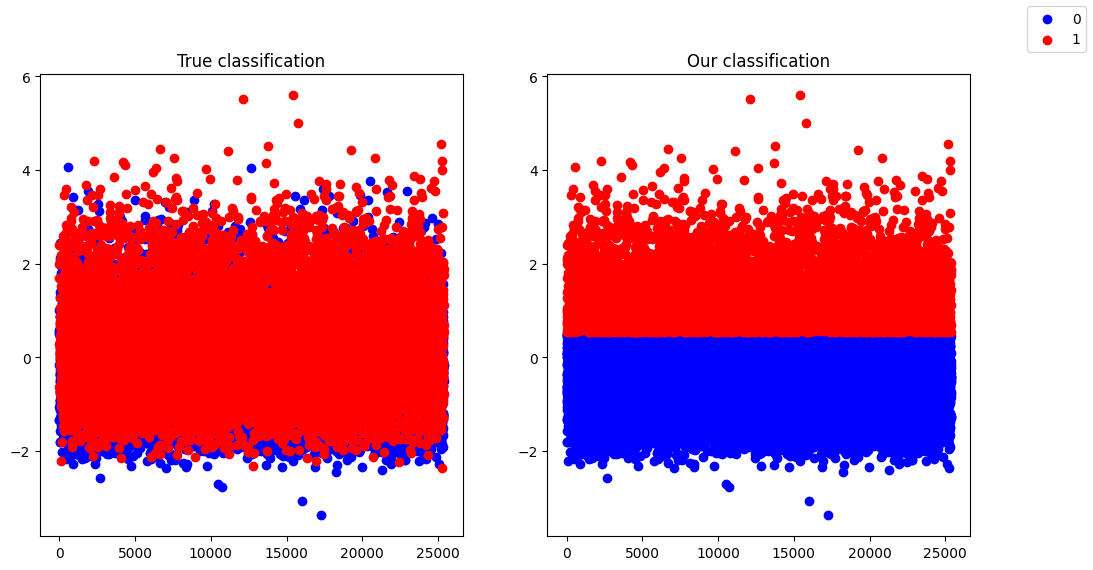

In [105]:
fig, ax = plt.subplots(1, 2)
x = np.arange(len(tst_lda))
ax[0].scatter(x[index0], tst_lda[index0], label="0", c="b")
ax[0].scatter(x[index1], tst_lda[index1], label="1", c="r")
ax[0].set_title("True classification")

ax[1].scatter(x[np.where(result==0)], class0, c="b")
ax[1].scatter(x[np.where(result==1)], class1, c="r")
ax[1].set_title("Our classification")

fig.set_size_inches(12, 6)
fig.legend()
plt.show()